In [ ]:
from IPython import display
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from lunar_operators import lunar_operators
from tianshou.data import Batch
from tianshou.utils.net.common import Net
from tianshou.policy import DQNPolicy
import os
import torch
from PIL import Image

VIEWPORT_W = 600
VIEWPORT_H = 400
SCALE = 30.0

# 物理世界尺寸 (米)
# X轴范围: [0, 20]
WORLD_W = VIEWPORT_W / SCALE
# Y轴范围: [0, 13.33]
WORLD_H = VIEWPORT_H / SCALE

# 关键参考点
CENTER_X = WORLD_W / 2  # 10.0
CENTER_Y = WORLD_H / 2  # 6.66 (用于缩放的分母)
HELIPAD_Y = WORLD_H / 4  # 3.33 (停机坪高度)


def convert_obs_to_physics(obs_x, obs_y):
    """
    将 Observation Space 坐标转换为 Box2D 物理坐标

    输入范围 (参考):
    obs_x: [-2.5, 2.5] (0是中心, 1是右边缘, -1是左边缘)
    obs_y: [-2.5, 2.5] (0是停机坪, 正数向上, 负数向下)
    """

    # X轴逆向公式: obs = (x - center) / center
    # => x = obs * center + center
    phys_x = (obs_x * CENTER_X) + CENTER_X

    # Y轴逆向公式: obs = (y - helipad) / (height/2)
    # => y = obs * (height/2) + helipad
    phys_y = (obs_y * CENTER_Y) + HELIPAD_Y

    return phys_x, phys_y


def teleport_lander(env, x, y, angle):
    """
    强制移动飞船 (包含腿部跟随)
    """
    lander = env.unwrapped.lander
    legs = env.unwrapped.legs

    # 记录旧位置用于计算相对位移
    old_pos = np.array(lander.position)
    old_angle = lander.angle

    # 旋转矩阵
    d_angle = angle - old_angle
    R = np.array(
        [[np.cos(d_angle), -np.sin(d_angle)], [np.sin(d_angle), np.cos(d_angle)]]
    )

    # 设置主体
    lander.position = (x, y)
    lander.angle = angle
    lander.linearVelocity = (0, 0)
    lander.angularVelocity = 0

    # 设置腿部
    for leg in legs:
        rel_pos = np.array(leg.position) - old_pos
        rotated_rel_pos = R.dot(rel_pos)
        leg.position = (x, y) + rotated_rel_pos
        leg.angle = leg.angle + d_angle
        leg.linearVelocity = (0, 0)
        leg.angularVelocity = 0


def render_perfect_snapshot(x, y, angle, action):
    # 初始化环境
    env = gym.make("LunarLander-v3", render_mode="rgb_array")
    env.reset()

    x, y, angle, action = float(x), float(y), float(angle), int(action)
    phys_x, phys_y = convert_obs_to_physics(x, y)
    # --- 第一次瞬移 ---
    # 将飞船摆放到位，准备喷射
    teleport_lander(env, phys_x, phys_y, angle)

    # --- 执行动作 ---
    # 这一步是为了生成喷射火焰的粒子效果
    # 物理引擎会根据当前位置计算火焰
    env.step(action)

    # --- 第二次瞬移 (修正) ---
    # step() 会产生反作用力推动飞船，导致位置微偏。
    # 为了精确构图，我们在渲染前再次将飞船强行按回原位。
    teleport_lander(env, phys_x, phys_y, angle)

    # --- 渲染 ---
    img_data = env.render()
    env.close()

    img = Image.fromarray(img_data)
    display.display(img)


class LogicalExpressionParser:
    def __init__(self, operators):
        self.operators = operators
        self.tokens = []
        self.current = 0

    def tokenize(self, expression):
        """将表达式字符串转换为token列表"""
        # 替换括号为带空格的形式，便于分割
        expression = expression.replace("(", " ( ").replace(")", " ) ")
        # 分割并移除空字符串
        self.tokens = [token for token in expression.split() if token]
        self.current = 0

    def peek(self):
        """查看当前token"""
        if self.current < len(self.tokens):
            return self.tokens[self.current]
        return None

    def advance(self):
        """移动到下一个token"""
        self.current += 1
        return self.tokens[self.current - 1]

    def parse(self, expression):
        """解析表达式"""
        self.tokenize(expression)
        return self.parse_expression()

    def parse_expression(self):
        """解析表达式"""
        if self.peek() == "(":
            return self.parse_group()
        elif self.peek() == "NOT":
            self.advance()  # consume NOT
            operand = self.parse_expression()
            return lambda x: ~operand(x)
        else:
            # 原子概念
            token = self.advance()
            return self.operators[token]

    def parse_group(self):
        """解析括号组"""
        self.advance()  # consume (
        left = self.parse_expression()

        while self.peek() in ["AND", "OR"]:
            operator = self.advance()
            right = self.parse_expression()

            if operator == "AND":
                left = self.create_and(left, right)
            else:  # OR
                left = self.create_or(left, right)

        self.advance()  # consume )
        return left

    @staticmethod
    def create_and(f1, f2):
        return lambda x: f1(x) & f2(x)

    @staticmethod
    def create_or(f1, f2):
        return lambda x: f1(x) | f2(x)


def parse_logical_expression(expression, operators):
    parser = LogicalExpressionParser(operators)
    return parser.parse(expression)


DEVICE = "cuda:0"
env1 = gym.make("LunarLander-v3")
state_shape = env1.observation_space.shape
action_shape = env1.action_space.n
# Create Q-network
net = Net(state_shape, hidden_sizes=[64] * 2, action_shape=action_shape, device=DEVICE)
q_net = net.to(DEVICE)

# Create policy
policy = DQNPolicy(
    model=q_net,
    optim=None,
    discount_factor=0.99,
    estimation_step=3,
    target_update_freq=500,
    reward_normalization=False,
    is_double=True,
    action_space=env1.action_space,
).to(DEVICE)
policy.eval()
# Load saved model
save_path = "/root/gym/rl_compexp/save/LunarLander-DQN64"
checkpoint = torch.load(os.path.join(save_path, "dqn.pth"))
policy.load_state_dict(checkpoint["model"])
hidden_outputs = []


def hook_fn(module, input, output):
    # Assuming output is a tensor, detach and move to CPU
    hidden_outputs.append(output.detach().cpu().numpy())


policy.model.model.model[2].register_forward_hook(hook_fn)

[[-0.100 0.090 0.050 -0.200 0.010 0.020 1.000 0.000]]
11.8624935
Batch(
    logits: tensor([[73.4332, 28.0011, 60.3709, 29.8105]], device='cuda:0',
                   grad_fn=<AddmmBackward0>),
    act: array([0]),
    state: None,
)
---------- 



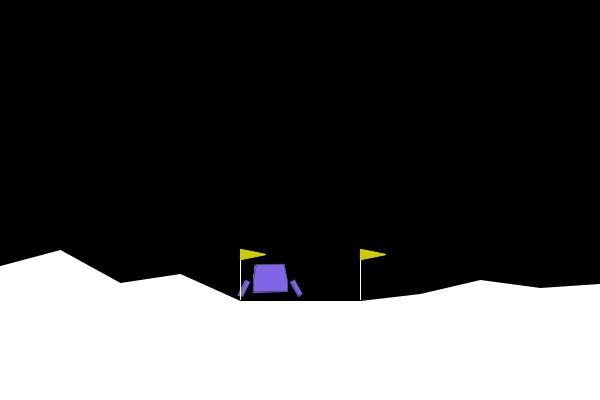

[[-0.300 0.400 -0.150 -0.100 -0.250 0.000 0.000 0.000]]
3.5392733
Batch(
    logits: tensor([[46.1059, 55.2105, 56.1323, 50.1671]], device='cuda:0',
                   grad_fn=<AddmmBackward0>),
    act: array([2]),
    state: None,
)
---------- 



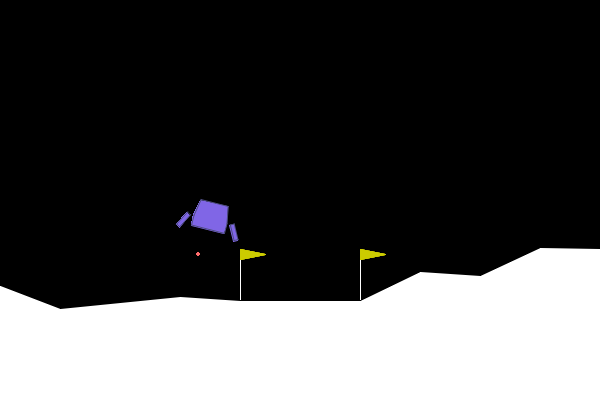

[[-0.100 1.200 0.000 0.000 0.000 0.000 0.000 0.000]]
-0.6961954
Batch(
    logits: tensor([[38.2723, 29.8790, 25.3157, 36.4840]], device='cuda:0',
                   grad_fn=<AddmmBackward0>),
    act: array([0]),
    state: None,
)
---------- 



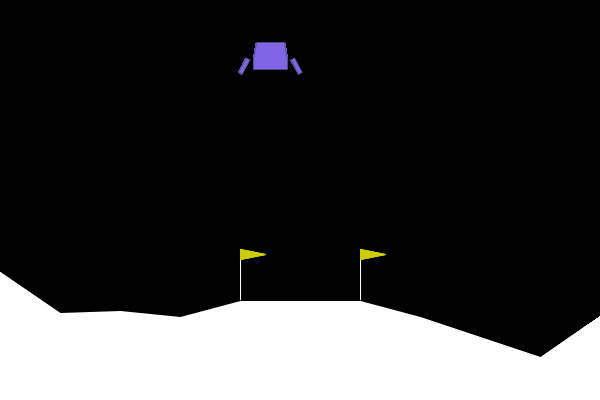

In [ ]:
# Neuron 9
expression = "((LLeg OR X1) AND (NOT Y4))"
neuron = 9
activation = np.load(
    "/root/gym/rl_compexp/save/LunarLander-DQN64/hidden_outputs.npy"
)
states = np.load("/root/gym/rl_compexp/save/LunarLander-DQN64/states.npy")
act = activation[:, neuron]
combined_function = parse_logical_expression(expression, lunar_operators)
result = combined_function(states)
# 均匀取10个满足条件的状态
filtered_states = states[result]
cnt_step = filtered_states.shape[0] / 10
indices = np.arange(0, filtered_states.shape[0], int(cnt_step))
selected_state = filtered_states[indices]
action = np.load(f"/root/gym/rl_compexp/save/LunarLander-DQN64/actions.npy")
selected_act = action[result][indices]
np.set_printoptions(formatter={"float": "{:.3f}".format})
# print(selected_state)
# for i in range(selected_state.shape[0]):
#     render_perfect_snapshot(
#         selected_state[i][0],
#         selected_state[i][1],
#         selected_state[i][4],
#         selected_act[i],
#     )
state1 = [-0.10, 0.09, 0.05, -0.20, 0.01, 0.02, 1.0, 0.0]
state2 = [-0.30, 0.40, -0.15, -0.10, -0.25, 0.00, 0.0, 0.0]
state3 = [-0.10, 1.20, 0.00, 0.00, 0.00, 0.00, 0.0, 0.0]
states = [state1, state2, state3]
for i in range(len(states)):
    obs = np.array(states[i])
    obs = Batch(obs=obs.reshape(1, -1), info={})
    action = policy.forward(obs)
    print(obs["obs"])
    print(hidden_outputs[-1][0][neuron])
    print(action)
    print("-" * 10, "\n")
    render_perfect_snapshot(
        states[i][0], states[i][1], states[i][4], int(action.act.item())
    )

special

[[0.050 0.800 0.100 -0.200 0.000 0.000 0.000 0.000]]
15.580593
Batch(
    logits: tensor([[51.3215, 49.1905, 43.7020, 50.7235]], device='cuda:0',
                   grad_fn=<AddmmBackward0>),
    act: array([0]),
    state: None,
)
---------- 



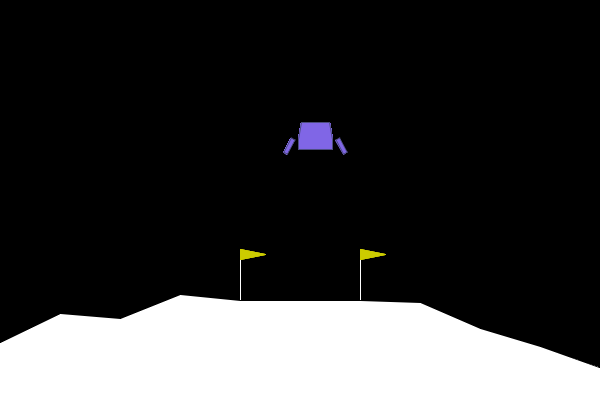

[[0.100 1.400 -0.200 0.050 0.030 0.070 0.000 0.000]]
14.631384
Batch(
    logits: tensor([[48.9406, 27.4847, 33.3965, 44.1131]], device='cuda:0',
                   grad_fn=<AddmmBackward0>),
    act: array([0]),
    state: None,
)
---------- 



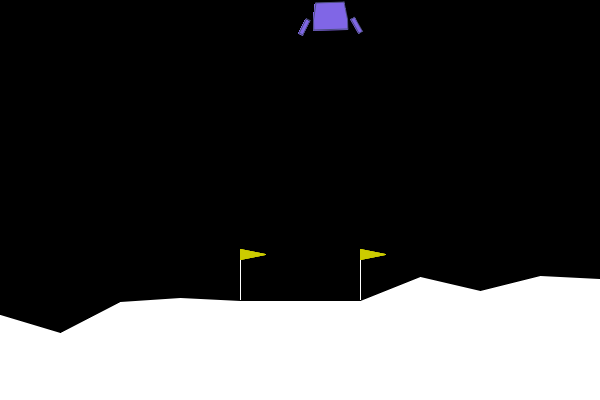

[[0.000 0.050 -0.500 0.000 0.000 -0.500 0.000 1.000]]
-7.3553305
Batch(
    logits: tensor([[51.3567, 54.8812, 66.6444, 61.3265]], device='cuda:0',
                   grad_fn=<AddmmBackward0>),
    act: array([2]),
    state: None,
)
---------- 



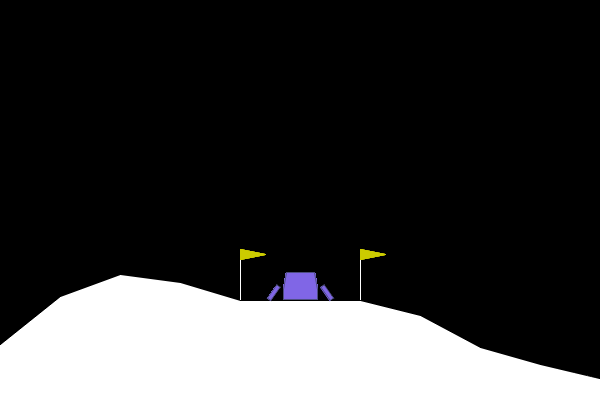

In [9]:
expression = "((((AV1 OR Vx3) AND (NOT RLeg)) OR Vx4) OR Y4)"
neuron = 41
states = [
    [0.05, 0.80, 0.10, -0.20, 0.00, 0.00000, 0, 0],
    [0.10, 1.40, -0.20, 0.05, 0.03, 0.07, 0, 0],
    [0.00, 0.05, -0.50, 0.00, 0.00, -0.5, 0, 1],
]
for i in range(len(states)):
    obs = np.array(states[i])
    obs = Batch(obs=obs.reshape(1, -1), info={})
    action = policy.forward(obs)
    print(obs["obs"])
    print(hidden_outputs[-1][0][neuron])
    print(action)
    print("-" * 10, "\n")
    render_perfect_snapshot(
        states[i][0], states[i][1], states[i][4], int(action.act.item())
    )

In [ ]:
from tianshou.data import Batch
from tianshou.utils.net.common import Net
from tianshou.policy import DQNPolicy
import torch

DEVICE = "cuda:0"
env = gym.make("LunarLander-v3")
state_shape = env.observation_space.shape
action_shape = env.action_space.n
# Create Q-network
net = Net(state_shape, hidden_sizes=[64] * 2, action_shape=action_shape, device=DEVICE)
q_net = net.to(DEVICE)

# Create optimizer (needed for policy creation)
optim = torch.optim.Adam(q_net.parameters(), lr=1e-3)

# Create policy
policy = DQNPolicy(
    model=q_net,
    optim=optim,
    discount_factor=0.99,
    estimation_step=3,
    target_update_freq=500,
    reward_normalization=False,
    is_double=True,
    action_space=env.action_space,
).to(DEVICE)
policy.eval()
# Load saved model
save_path = "/root/gym/rl_compexp/save/LunarLander-DQN64"
checkpoint = torch.load(os.path.join(save_path, "dqn.pth"))
policy.load_state_dict(checkpoint["model"])
hidden_outputs = []


def hook_fn(module, input, output):
    # Assuming output is a tensor, detach and move to CPU
    hidden_outputs.append(output.detach().cpu().numpy())


policy.model.model.model[2].register_forward_hook(hook_fn)

for index in range(selected_state.shape[0]):
    obs = selected_state[index]
    obs = Batch(obs=obs.reshape(1, -1), info={})
    policy.forward(obs)
    print(obs["obs"])
    print(hidden_outputs[index][0][neuron])

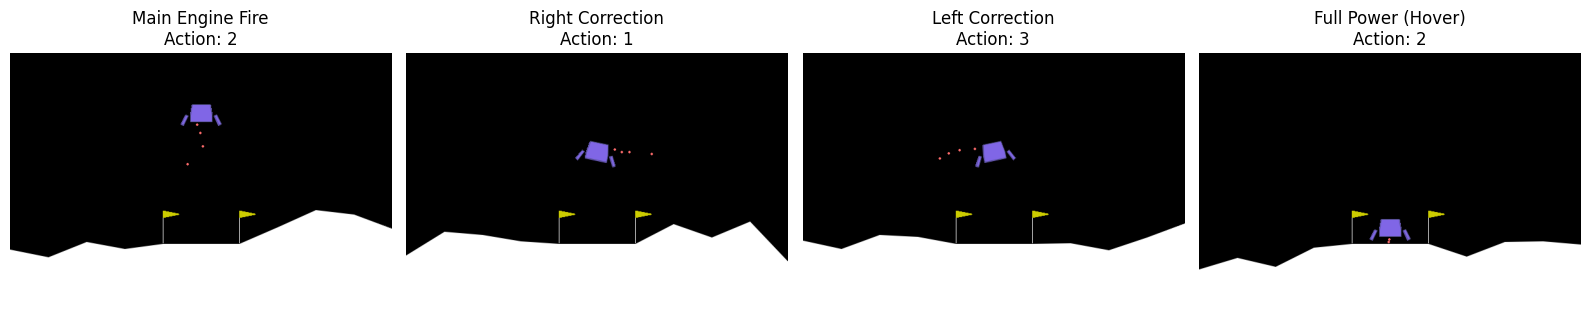

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt


# --- 这里保留之前的 set_lander_state 函数 ---
def set_lander_state(env, x, y, angle, vx, vy, omega):
    unwrapped = env.unwrapped
    lander = unwrapped.lander
    legs = unwrapped.legs

    old_pos = np.array(lander.position)
    new_pos = np.array([x, y])
    d_angle = angle - lander.angle

    lander.position = (float(x), float(y))
    lander.angle = float(angle)
    lander.linearVelocity = (float(vx), float(vy))
    lander.angularVelocity = float(omega)

    R = np.array(
        [[np.cos(d_angle), -np.sin(d_angle)], [np.sin(d_angle), np.cos(d_angle)]]
    )

    for leg in legs:
        rel_pos = np.array(leg.position) - old_pos
        rotated_rel_pos = R.dot(rel_pos)
        new_leg_pos = new_pos + rotated_rel_pos
        leg.position = (float(new_leg_pos[0]), float(new_leg_pos[1]))
        leg.angle = leg.angle + d_angle
        leg.linearVelocity = (float(vx), float(vy))
        leg.angularVelocity = float(omega)

    lander.Awake = True
    for leg in legs:
        leg.Awake = True


# --- 新增：带动作渲染的辅助函数 ---


def render_with_action(env, params, action, flame_length=5):
    """
    在指定状态下渲染特定动作的火焰效果。

    参数:
        env: 环境
        params: 包含 x, y, angle 等状态的字典
        action: 0(无), 1(左引擎), 2(主引擎), 3(右引擎)
        flame_length: 模拟步数。数值越大，火焰拖尾越长。
    """
    # 解包参数
    x, y, angle = params["x"], params["y"], params["angle"]
    vx, vy, omega = params["vx"], params["vy"], params["omega"]

    # 循环几次 step，为了积累粒子效果，让火焰看起来更丰满
    for _ in range(flame_length):
        # 1. 先把飞船按在原地 (确保粒子从正确的位置发射出来)
        set_lander_state(env, x, y, angle, vx, vy, omega)

        # 2. 执行动作 (生成粒子，物理引擎会计算一步，飞船会微动)
        env.step(action)

    # 3. 最后一次强制归位 (确保截图时的飞船位置是精确的)
    set_lander_state(env, x, y, angle, vx, vy, omega)

    # 4. 渲染
    return env.render()


# --- 主程序 ---

env = gym.make("LunarLander-v3", render_mode="rgb_array")

# 定义场景：包含动作 (Action)
# Action Map: 0:None, 1:Left Engine(向右喷), 2:Main Engine(向下喷), 3:Right Engine(向左喷)
scenarios = [
    {
        "name": "Main Engine Fire",
        "action": 2,  # 主引擎
        "params": {"x": 10, "y": 10, "angle": 0, "vx": 0, "vy": -1, "omega": 0},
    },
    {
        "name": "Right Correction",
        "action": 1,  # 左引擎喷射（推向右边）
        "params": {"x": 10, "y": 8, "angle": -0.2, "vx": 0, "vy": 0, "omega": 0},
    },
    {
        "name": "Left Correction",
        "action": 3,  # 右引擎喷射（推向左边）
        "params": {"x": 10, "y": 8, "angle": 0.2, "vx": 0, "vy": 0, "omega": 0},
    },
    {
        "name": "Full Power (Hover)",
        "action": 2,  # 主引擎悬停
        "params": {"x": 10, "y": 4, "angle": 0, "vx": 0, "vy": 0, "omega": 0},
    },
]

fig, axes = plt.subplots(1, len(scenarios), figsize=(16, 4))

for i, s in enumerate(scenarios):
    env.reset()

    # 使用新的函数来渲染
    # flame_length 可以调节，3-5 比较合适，太大了粒子会散开
    img = render_with_action(env, s["params"], s["action"], flame_length=4)

    axes[i].imshow(img)
    axes[i].set_title(f"{s['name']}\nAction: {s['action']}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()
env.close()

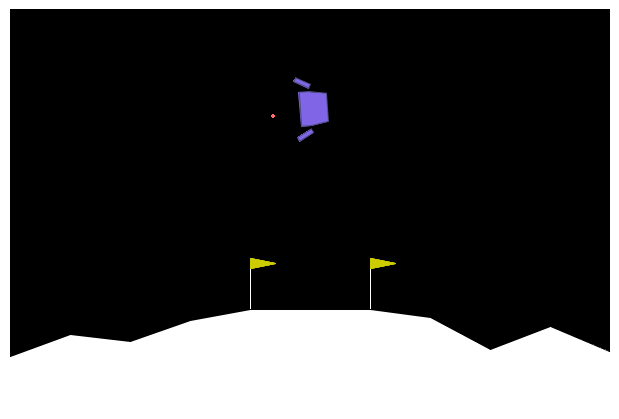

In [12]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np


def teleport_lander(env, x, y, angle):
    """
    将飞船主体和腿作为一个整体移动到指定位置和角度。
    """
    lander = env.unwrapped.lander
    legs = env.unwrapped.legs

    # 1. 获取当前状态（移动前）
    old_pos = np.array(lander.position)
    old_angle = lander.angle

    # 2. 计算变换所需的旋转矩阵
    # 我们需要将腿从"旧角度"旋转到"新角度"
    d_angle = angle - old_angle
    # 2D 旋转矩阵
    R = np.array(
        [[np.cos(d_angle), -np.sin(d_angle)], [np.sin(d_angle), np.cos(d_angle)]]
    )

    # 3. 移动主体 (Hull)
    lander.position = (x, y)
    lander.angle = angle
    lander.linearVelocity = (0, 0)
    lander.angularVelocity = 0

    # 4. 移动腿 (Legs)
    for leg in legs:
        # 计算腿相对于旧主体的向量
        rel_pos = np.array(leg.position) - old_pos

        # 旋转这个向量
        rotated_rel_pos = R.dot(rel_pos)

        # 设定腿的新位置 = 新主体位置 + 旋转后的相对向量
        leg.position = (x, y) + rotated_rel_pos

        # 设定腿的新角度
        leg.angle = leg.angle + d_angle

        # 清空腿的速度，防止物理引擎在渲染瞬间产生模糊或位移
        leg.linearVelocity = (0, 0)
        leg.angularVelocity = 0


def render_perfect_snapshot(x, y, angle, action):
    # 初始化环境
    env = gym.make("LunarLander-v3", render_mode="rgb_array")
    env.reset()

    # --- 第一次瞬移 ---
    # 将飞船摆放到位，准备喷射
    teleport_lander(env, x, y, angle)

    # --- 执行动作 ---
    # 这一步是为了生成喷射火焰的粒子效果
    # 物理引擎会根据当前位置计算火焰
    env.step(action)

    # --- 第二次瞬移 (修正) ---
    # step() 会产生反作用力推动飞船，导致位置微偏。
    # 为了精确构图，我们在渲染前再次将飞船强行按回原位。
    teleport_lander(env, x, y, angle)

    # --- 渲染 ---
    img_data = env.render()
    env.close()

    # --- 极简绘图 ---
    height, width, _ = img_data.shape
    fig = plt.figure(figsize=(width / 100, height / 100), dpi=100)
    ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])  # 占满全图
    ax.set_axis_off()
    fig.add_axes(ax)

    ax.imshow(img_data)
    plt.show()


# ==========================================
# 参数设置
# ==========================================
# x=10, y=10: 屏幕居中偏上
# angle=-0.5: 明显的向右倾斜
# action=2: 主引擎喷火
# 此时你会看到腿部完美地跟随着倾斜的机身
render_perfect_snapshot(x=10, y=10, angle=-1.5, action=2)